# Electrostatic simulation of a quantum dot device
In the current work we implement the geometry of a proposed device for creating a quantum dot. We solve the electrostatic PDE using the finite element method and using the diffusive solver python package.

In [1]:
# Imports
from diffusive_solver import *
from create_mesh_device import create_geometry_mesh  # Needen to greate the mesh (.gmsh file)
import plot_electrostatics as plot

## Parameter definition

We must identify all the variables that define the geometry of the device. These are the parameters defining the shape of the patterned gate ($d, w, r, h$ and $diam$), the width of the insulators $t_i$ and the width of the golden gate $w_g$.

![Alt text](Figures/scheme_lateral.png "Lateral")
![Alt text](Figures/scheme_top.png "Top")

Definition of the parameters following the above figures. Parameters chosen following experimentalit's advice to provide a realistic example.

In [2]:
# Parameters
geom_params = {'Lx':600, #nm
'Ly':500,
't1':30,
'd':120,
't2':12, 
'w':300,
'r':100,
'h':100,
'diam':40,
't3':12,
'w_g':120}
c = [0.0, 0.0, 0.0]  # center point (starting point: do not change!)
lc = 30  # parameter that defined the size of the mesh parts. The smaller, the more precise, but the longer it takes.
         # to recreate the results of the thesis, use lc = 10
file_mesh = "meshes/FINAL_device.msh"  # our output mesh will be stored like this
n_contacts = 3  # our device has 3 contacts/gates , i.e., defined physical surfaces in the mesh created by gmesh

Create the geometry with the given parameters using gmsh. We use the program create_geometry_mesh of the file create_mesh.py.

In [3]:
create_geometry_mesh(geom_params, lc, c, file_mesh)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
Info    : [ 40%] Meshing curve 25 (Line)
Info    : [ 40%] Meshing curve 26 (Line)
Info    : [ 40%] Meshing curve 27 (Line)
Info    : [ 40%] Meshing curve 28 (Line)
Info    : [ 40%] Meshing curve 50 (Circle)
Info    : [ 50%] Meshing curve 51 (Circle)
Info    : [ 50%] Meshing curve 52 (Circle)
Info    : [ 50%] Meshing curve 53 (

Load the mesh and visualize some aspects of it to check we have the spected geometry and mesh.

In [4]:
geometry = Geometry.from_msh_file(file_mesh, n_contacts = n_contacts,dim=3)  # We take the geometry from the created mesh.
geometry.mesh  # Viasualize the mesh

ode relocations (volume = 3.6e+06): worst = 0.150011 / average = 0.709164 (Wall 0.0023404s, CPU 0s)
Info    : No ill-shaped tets in the mesh :-)
Info    : 0.00 < quality < 0.10 :         0 elements
Info    : 0.10 < quality < 0.20 :         1 elements
Info    : 0.20 < quality < 0.30 :         5 elements
Info    : 0.30 < quality < 0.40 :        67 elements
Info    : 0.40 < quality < 0.50 :       102 elements
Info    : 0.50 < quality < 0.60 :       148 elements
Info    : 0.60 < quality < 0.70 :       776 elements
Info    : 0.70 < quality < 0.80 :      1469 elements
Info    : 0.80 < quality < 0.90 :       432 elements
Info    : 0.90 < quality < 1.00 :        30 elements
Info    : Done optimizing mesh (Wall 0.01482s, CPU 0.015625s)
Info    : 2071 nodes 13521 elements
Info    : Writing 'meshes/FINAL_device.msh'...
Info    : Done writing 'meshes/FINAL_device.msh'

Total volume = 16200000.000000037
Total area = 718799.9999999997
Subdomain 1 with volume = 0.0
Subdomain 2 with volume = 0.0
Subdo

Define the other variables of the problem: the dielectric constants (eps) and the voltages applied in each contact.
Then solve the variational problem.
For more information on how the parameters are defined in the package diffusive_solver, see https://doi.org/10.48550/arXiv.2011.04351.

In [5]:
# We first store the matrices of the dieletrics constants in a dictonary as 'material' : eps.
# This allows as to change them more easily.
dielec_constants = {'hBN': np.array([[6.7,0, 0],
                            [0, 6.7, 0],
                            [0, 0, 3.56]]),
                  'SiO2': np.array([[2.51,0, 0],
                            [0,2.51, 0],
                            [0, 0, 2.51]]),
                  'Al2O3':np.array([[9.0, 0, 0],
                            [0, 9.0, 0],
                            [0, 0, 9.0]])}

# We chose which dielectric constant (i.e., material) corresponds to each volume in the device.
# They are taken in the way: {tag of volume : dielec_constants['material']}
# The mesh has been generated so that the volume between the BB and the BLG is the volume 1 (tag=1),
# the one between BLG and PG is volume 2 and the one between the PG and the GG is volume 3.

eps = Matrix_Expression({1: dielec_constants['hBN'], 
                        2: dielec_constants['hBN'],
                        3: dielec_constants['Al2O3']},
                       dimension = 3, marker = geometry.subdomain_marker, scalar = False)
voltages = [0, 2, -3] # Voltage in  the gates: back gate, patterned gate and golden gate, respectively.

# Definition of the problem by providing the geometry for the FEM, the only matr
problem = Problem(geometry = geometry, L = [[eps]], biases = [voltages]) 
problem.solve()  # Solve it
# problem.save('testing_results/3dsolution') uncomment this line to save the results

Solving linear variational problem.


## Plotting the results
We have already solved the equations, which means we have the electronic potential and the displacement current in all the points inside the device.
Now, we will proceed to plot the potential and the displacement field in different views.

### Electronic potential energy V
We plot $V = -e \phi$ , where $\phi$ is the field we have obtained with our program.

In [6]:
field = problem.fields[0]   # The electric potential 𝜙 in any x,y,z point inside the device is problem.fields[0](x, y, z)

Potential enegy in the bilayer graphene


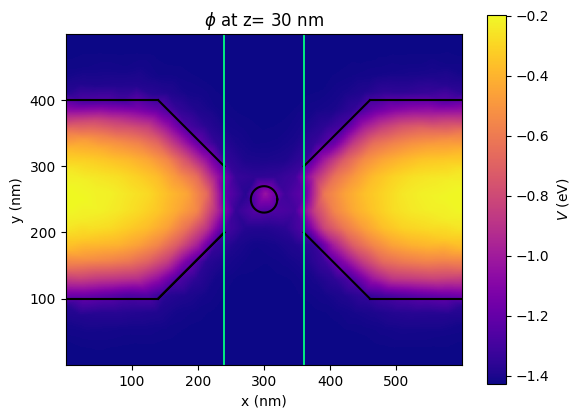

In [7]:
print('Potential enegy in the bilayer graphene')
plot.plot_V_xy(field, geom_params, zp=30)  # 30 is the height of the BLG

Potential enegy inside the device, passing throught the middle of the hole


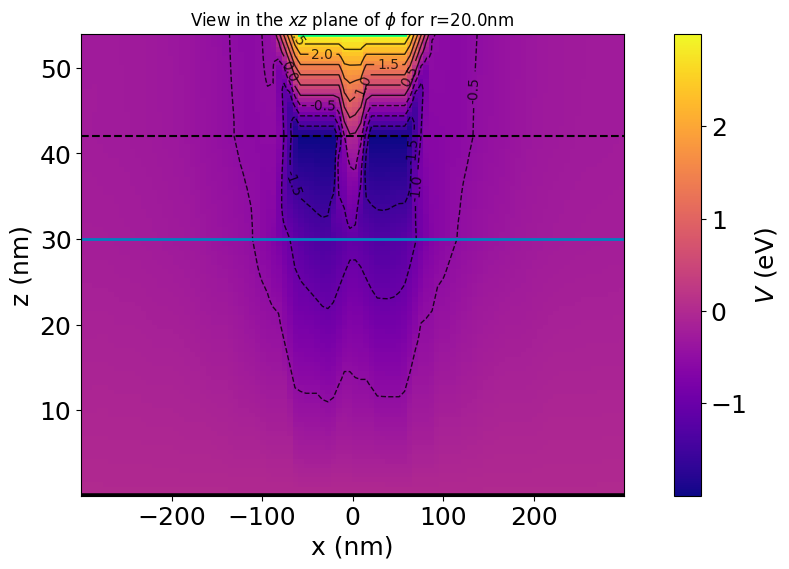

In [8]:
print('Potential enegy inside the device, passing throught the middle of the hole')
plot.plot_V_xz(field, geom_params, yp=250)  # The point in y chosen is Ly/2,
                                           #so that the plane passes through the center of the hole

### $\Delta$
We plot $\Delta = e t_z D_z$, where $D_z$ is the $z$ component of the displacement field (named current in the progam) we obtained and $t_z$ if the distance between layers in BLG (0.34nm).

In [9]:
dfield = problem.currents[0] # The displacement current in vector direction j Dj (j = 1, 2, 3 for x, y, z directions) 
                             # in any x,y,z point inside the device is problem.currents[0, j](x, y, z)

Displacement field in the patterned gate


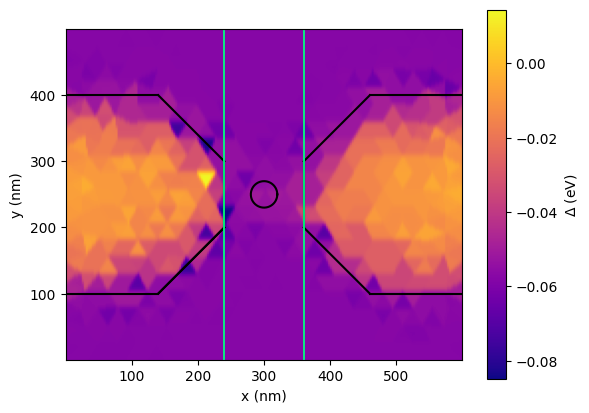

In [10]:
print('Displacement field in the patterned gate')
plot.plot_delta_xy(dfield, geom_params, 30)